## Gaussan process analysis of a single-cell RNA-Seq time course

As an example of how we can study single cell time courses using Gaussian Processes,
we will look at data from [Single-cell RNA-seq reveals dynamic paracrine control of cellular variation](http://www.nature.com/nature/journal/v510/n7505/full/nature13437.html). The original study is a large one with several single cell RNA-seq experiments, combined reaching 1700 cells. We will focus on one experiment.

This is a time course, where murine bone marrow derived dendritic cells (BMDCs) are stimulated by lipopolysaccharide (LPS). The subset of cells we will look at have been collected and sequenced at different time points after stimulation has been initiated. Specifically after 1, 2, 4, and 6 hours.

The scrnatab library is available at https://github.com/Teichlab/scrnatb

In [1]:
%pylab inline
%run ../scrnatb/scrnatb/toolbox.py

Populating the interactive namespace from numpy and matplotlib


Included in this repo is a TPM table which only contains expression from ~300 cells which was part of the time course we are interested in.

In [8]:
tpm = pd.read_csv('bmdc-data/lps_tpm.csv', index_col=0)

We remove genes which are not expresses (except in a couple of cells at most). This speeds up the BGPLVM a bit, but does not affect the results. If genes are all zeros, they are not going to contribute information about the structure of the data.

In [14]:
tpm = tpm[(tpm > 10).sum(1) > 2]
tpm.sort_index(inplace=True)

In [15]:
tpm.iloc[:5, :5]

,SRR936376,SRR936380,SRR936384,SRR936392,SRR936396
0,,,,,
(CAA)n,0.0,0.0000,0.0,0.0,0.0000
(CAAAA)n,0.0,0.0000,0.0,0.0,0.0000
(CAAAAA)n,0.0,0.0000,0.0,0.0,0.0000
(CCCTAA)n,0.0,0.0000,0.0,0.0,22.1225
(CCTA)n,0.0,32.1405,0.0,0.0,0.0000


In [16]:
tpm.shape

(18413, 335)

We also have meta data about these cells

In [17]:
sample_info = pd.read_csv('bmdc-data/sample_info_lps.csv', index_col=0)

In [20]:
sample_info.head(4).T

Run_s,SRR936376,SRR936380,SRR936384,SRR936392
BioSample_s,SAMN02257004,SAMN02257000,SAMN02256999,SAMN02257002
Experiment_s,SRX324195,SRX324196,SRX324197,SRX324199
LoadDate_s,2013-07-17,2013-07-17,2013-07-17,2013-07-17
MBases_l,308,223,337,307
MBytes_l,224,158,241,221
Sample_Name_s,GSM1189418,GSM1189419,GSM1189420,GSM1189422
source_name_s,BMDC (1h LPS Stimulation),BMDC (1h LPS Stimulation),BMDC (1h LPS Stimulation),BMDC (1h LPS Stimulation)
stimulation_s,1h LPS Stimulation,1h LPS Stimulation,1h LPS Stimulation,1h LPS Stimulation
strain_s,C57BL/6,C57BL/6,C57BL/6,C57BL/6
Assay_Type_s,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq


Compared to the frog time course we looked at in Part 2, here we have much more information. The table was downloaded from [ArrayExpress](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-48968/samples/?full=true) together with the raw data which was then quantified with Salmon.

In [224]:
sample_info.stimulation_s.value_counts()

4h LPS Stimulation    88
1h LPS Stimulation    87
6h LPS Stimulation    81
2h LPS Stimulation    79
Name: stimulation_s, dtype: int64

As descriibed before, we log scale the TPMs

In [26]:
logexp = np.log10(tpm + 1)

In this data, I found that the number of genes per sample greatly dominate the observed expression variability. Before we continue, we regress out this effect. This is not always needed, and it affects the interpretation of the data somewhat. For the sake of this example though, we'll just do it and not think about it too much.

The `de.py` script in `scrnatb` contains an implementaion of `limma:removeBatchEffect`, which works all right in simple cases like this where there's no confounding.

In [28]:
%run /nfs/research2/teichmann/valentine/scrnatb/scrnatb/de.py

In [29]:
regressed = regress_out(sample_info, logexp, 'n_genes')

In [31]:
regressed.iloc[:5, :5]

,SRR936376,SRR936380,SRR936384,SRR936392,SRR936396
0,,,,,
(CAA)n,-0.121189,-0.086834,-0.134101,-0.145122,-0.129836
(CAAAA)n,0.011444,0.008200,0.012664,0.013705,0.012261
(CAAAAA)n,-0.315705,-0.226207,-0.349342,-0.378050,-0.338230
(CCCTAA)n,-0.327718,-0.234815,-0.362635,-0.392436,1.012934
(CCTA)n,-0.739168,0.990734,-0.817923,-0.885138,-0.791907


Now, we use a Bayesian GPLVM as discussed in 3. to find a low-dimensional representation of the data.

In [32]:
import GPy

In [33]:
bgplvm = GPy.models.BayesianGPLVM(regressed.T.as_matrix(), input_dim=5)

In [34]:
# This takes 2-3 minutes
bgplvm.optimize(messages=True, max_iters=2000)

In [36]:
bgplvm

bayesian_gplvm.,value,constraints,priors
latent space.mean,"(335, 5)",,
latent space.variance,"(335, 5)",+ve,
inducing inputs,"(10, 5)",,
rbf.variance,0.353538479038,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,0.219391859568,+ve,


In [35]:
# Make sure that metadata and data has the same order
sample_info = sample_info.ix[logexp.columns]

In [37]:
sns.set_style('whitegrid')
sns.set_context('talk')

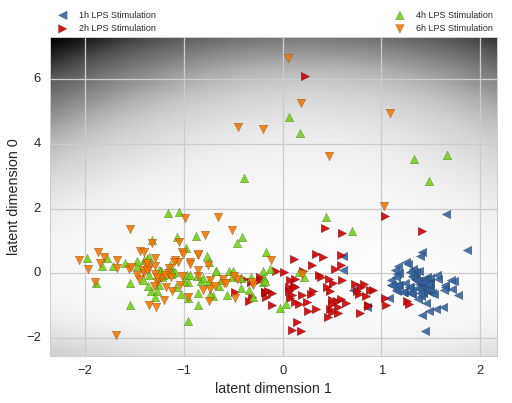

In [41]:
figsize(8, 6)
bgplvm.plot_latent(labels=sample_info.stimulation_s[logexp.columns], scatter_kwargs={'s': 75});

We pretty clearly see that the stimulation time course can be immidiatly explained by 'latent dimension 1'.

The plot command of a `BaysianGPLVM` automatically order the latent dimensions so that the X-axis has the most informative dimension, and the Y-axis the second most informative. We can evaluate how informative the latent dimensions are by what is called Automatic Relevance Determination (ARD). This uses the inferred lengthscale of a latent dimension to see how variable the data is across it. A low sensitivity in an ARD means that genes are mostly constant and explained by random noise in those latent dimensions.

The GPy kernels have a command for plotting the ARD.

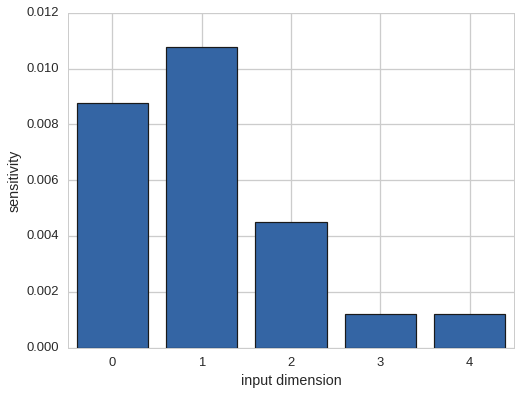

In [43]:
bgplvm.kern.plot_ARD();

This shows us the relation between the variables. There seem to be some signal in the dimensions 0 and 2 as well as in 1. From the plot above it seems some particular small population of cells are causing the information in dimension 0. For now, we will not investigate other dimensions than 1.

We consider latent dimension 1 to be the _pseudotime_, a 1-dimensional variable which parametrizes a curve in expression space, which the cells follow.

Since we can see that 1h is on the right and 6h is on the left, we negate the pseudotime before we use it, to make it easier to interpret. (None of the analysis cares which direction it goes).

In [45]:
sample_info['pseudotime'] = -bgplvm.latent_space[:, 1].mean

Let's also put in the real time in a variable so that we can use it for comparing with our results.

In [58]:
sample_info['hour'] = sample_info['stimulation_s'].str.get(0)

In [Bayesian Gaussian Process Latent Variable Models for pseudotime inference in single-cell RNA-seq data](http://biorxiv.org/content/early/2015/09/15/026872) it was pointed out that if the uncertainty of the estimates of the pseudotime is high, it might not be useful. We can illustrate how certain the pseudotime is by plotting it against itself for each cell, but in one axis include the confidence interval.

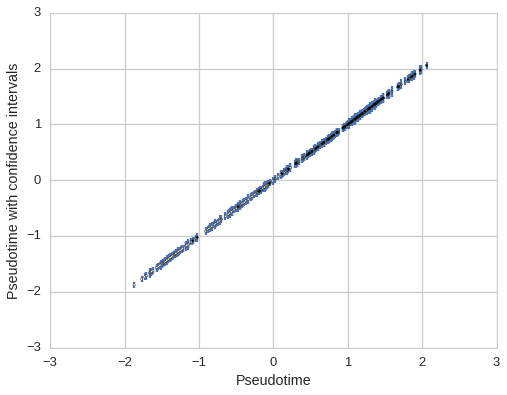

In [64]:
pseudotime_CI = 2 * np.sqrt(bgplvm.latent_space[:, 1].variance)
plt.errorbar(sample_info.pseudotime, sample_info.pseudotime, yerr=pseudotime_CI, fmt='none');
plt.scatter(sample_info.pseudotime, sample_info.pseudotime, marker='.', zorder=2, c=sample_info.hour)
sns.axlabel('Pseudotime', 'Pseudotime with confidence intervals')

We see here that there is some uncertainty, a given cell seem to fall within confidence intervals of maybe 5 or so other cells. But the pseudotime uncertanity seems much smaller than any data noise we would see.

Let's load some gene annotations as well, since our TPM table is just indexed by indecipherable Ensembl IDs.

In [65]:
gene_annotation = pd.read_csv('bmdc-data/mouse_annotation.csv', index_col=0)
gene_annotation.head()

,gene_name,transcript_count,chromosome,gene_start,gene_type
SQR4_MM,SQR4_MM,1,SQR4_MM,1,repeat
SQR1_MM,SQR1_MM,1,SQR1_MM,1,repeat
SATMIN,SATMIN,1,SATMIN,1,repeat
RMER6D,RMER6D,1,RMER6D,1,repeat
RMER21B,RMER21B,1,RMER21B,1,repeat


In the original paper the authors of the write that Stat2 increases over time as a response to LPS, so let's use that as an example of gene expression over pseudotime.

In [68]:
gene_annotation[gene_annotation.gene_name.str.contains('Stat')]

,gene_name,transcript_count,chromosome,gene_start,gene_type
ENSMUSG00000026104,Stat1,12,1,52119440,protein_coding
ENSMUSG00000002147,Stat6,5,10,127642986,protein_coding
ENSMUSG00000040033,Stat2,2,10,128270576,protein_coding
ENSMUSG00000004043,Stat5a,7,11,100859351,protein_coding
ENSMUSG00000062939,Stat4,4,1,51987148,protein_coding
ENSMUSG00000020919,Stat5b,3,11,100780731,protein_coding
ENSMUSG00000004040,Stat3,14,11,100885098,protein_coding


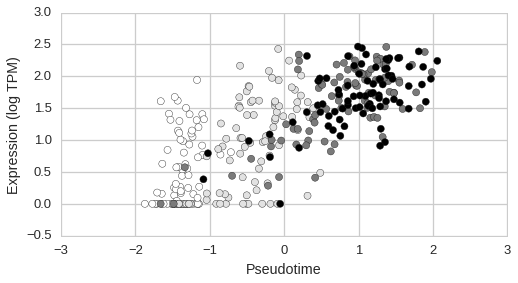

In [72]:
figsize(8, 4)
plt.scatter(sample_info['pseudotime'], logexp.ix['ENSMUSG00000040033'], s=50, c=sample_info.hour);
sns.axlabel('Pseudotime', 'Expression (log TPM)')

We can compare this to time-point based plot in the same way

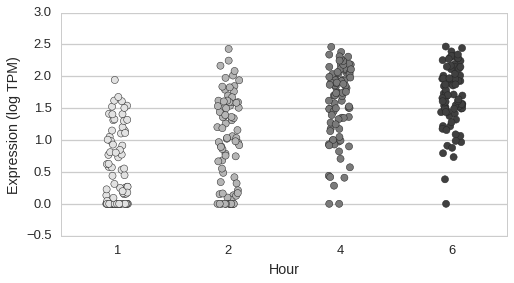

In [99]:
temp = sample_info[['hour']].copy()
temp['expression'] = logexp.ix['ENSMUSG00000040033']
sns.stripplot('hour', 'expression', data=temp, jitter=True, s=np.sqrt(50), palette='Greys', lw=0.5);
sns.axlabel('Hour', 'Expression (log TPM)')

In either case we can see that Stat2 increases over time. But with pseudotime, we have a notion of _early_ and _late_ cells in a given time point.

Let us also illustrate GP regression over pseudotime. This is just like in the time course case, but we look at pseudotime rather than actual time as a predictor variable.

In [110]:
X = sample_info['pseudotime'][:, None]
Y = logexp.ix['ENSMUSG00000040033'][:, None]

model = GPy.models.GPRegression(X, Y)
model.optimize()
model

GP_regression.,value,constraints,priors
rbf.variance,1.93578089687,+ve,
rbf.lengthscale,3.54732195883,+ve,
Gaussian_noise.variance,0.242715925735,+ve,


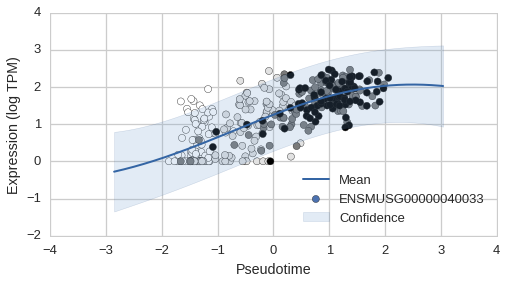

In [112]:
plt.scatter(sample_info['pseudotime'], logexp.ix['ENSMUSG00000040033'], s=50, c=sample_info.hour);
model.plot(plot_data=False, ax=plt.gca(), legend=False);
plt.legend(loc='lower right');
sns.axlabel('Pseudotime', 'Expression (log TPM)')

As you might appreciate, the confidence interval is much wider here than in the frog time course in part 2. This is something we have to live with when we are working with these noisy systems, and makes you appreciate well controlled time course experiments!

Now, we take this further and perform the same analysis as for the frog embryos, using pseudotime as the X-values.

This has been performed already as well, we just read in the results.

In [144]:
gps_rbf  = pd.read_csv('bmdc-data/gp_rbf.csv',  index_col=0)
gps_bias = pd.read_csv('bmdc-data/gp_bias.csv', index_col=0)

And calculate the D statistic

In [150]:
D = -2 * gps_bias['log_likelihood'] + 2 * gps_rbf['log_likelihood']

In [151]:
# We predicted at these points for each gene
xx = np.linspace(-2.5, 2.5, 200)[:,None]

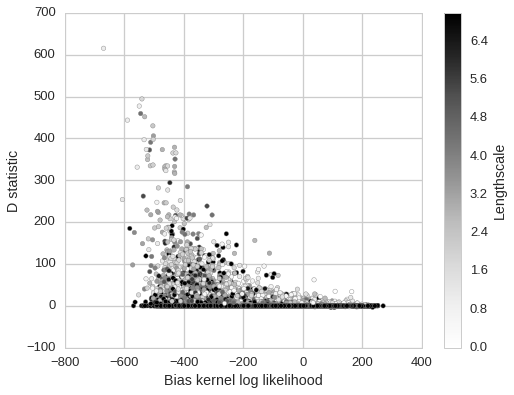

In [155]:
figsize(8, 6)

plt.scatter(gps_bias['log_likelihood'], D,
            edgecolor='grey',
            c=gps_rbf['rbf.lengthscale'], vmin=0, vmax=7.)
plt.colorbar(label='Lengthscale')

sns.axlabel('Bias kernel log likelihood', 'D statistic')

This is also not as nice as with the frogs, but we can see some genes are fairly high on the D axis.

In [166]:
varying = D[(D > 75)].index
varying.shape

(324,)

Like before, we find the peak, and order the pseudotime-varying genes.

In [167]:
gp_features = pd.DataFrame(index=gps.index)
gp_features = gp_features.ix[gps.index]
gp_features['peaktime'] = xx[gps.ix[:, 4:204].as_matrix().argmax(1)]

In [168]:
varying = gp_features.ix[varying].sort_values('peaktime', ascending=True).index

In [169]:
from sklearn import preprocessing

In [170]:
M = preprocessing.scale(gps.ix[varying, 4:204], 1)

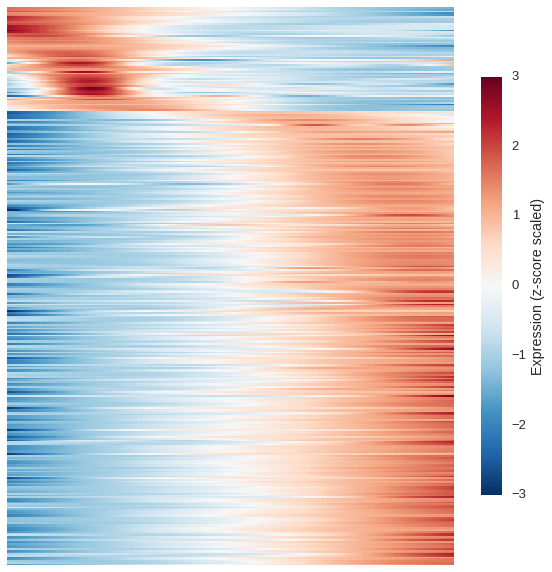

In [171]:
figsize(10, 10)
sns.heatmap(M, lw=0,
            yticklabels=False,
            xticklabels=False,
            cbar_kws={'label': 'Expression (z-score scaled)', 'shrink':.75},
            cmap=cm.RdBu_r, vmin=-3, vmax=2.5);


This is interesting in general. It doesn't have the same wave pattern as the developing embryos. Those waves probably only happen in very synchronized cell types.

We can however see a number of different patterns here. How do we extract these patterns?

There is a clustering algorithm for this, called Mixtures of Heirarchical Gaussan Processes (MoHGP). It aims to find underlying Gaussian Processes which correspond to a pattern, and assign individual Gaussian Processes for the data of each gene to those underlying trends.

It is feasible to run using the reduced list of varying genes. It is implemented in the [GPclust](https://github.com/SheffieldML/GPclust) package, separate from GPy, but uses componentes of GPy.

In [172]:
import GPclust

In [173]:
k_underlying = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=2.5)
k_corruption = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.3) + GPy.kern.White(input_dim=1, variance=0.01)

mohgp = GPclust.MOHGP(sample_info.pseudotime[:, None],
                      k_underlying,
                      k_corruption,
                      logexp.ix[varying].as_matrix(),
                      K=4, prior_Z='DP', alpha=1.0)

We define a covariance function for the underlying trends, then another covariance function which describes each genes deviateion from the underlying trend. This is what is heirarchical about the model.

We also provide an upper guess to the number of clusters. Here I guess 4.

We can see the first random assignments to the clusters before optimization to compare.

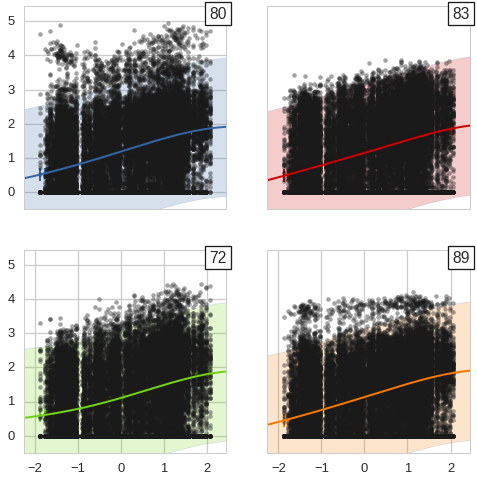

In [176]:
figsize(8, 8)
mohgp.plot(on_subplots=True, colour=True, newfig=False, joined=False, data_in_grey=True, errorbars=True)

In [177]:
# This takes ~5 minutes.
mohgp.optimize()

 /nfs/research2/teichmann/valentine/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


Now the interesting bit, these are the clusters after optimization.

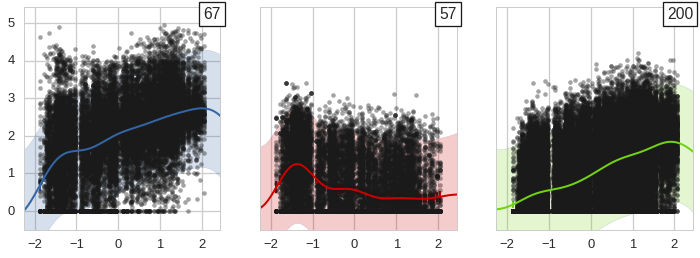

In [185]:
figsize(12, 4)
mohgp.plot(on_subplots=True, colour=True, newfig=False, joined=False, data_in_grey=True, errorbars=True)

The model finds that 3 clusters are sufficient for the data, and they have distinct patterns as we would expect.

To make it a bit easier to see what is going on, we can plot the underlying trends in a single figure.

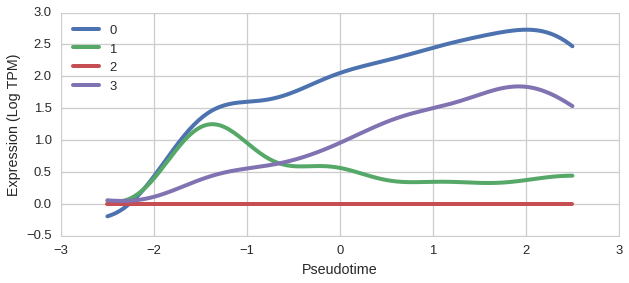

In [188]:
figsize(10, 4)
for i in range(4):
    plt.plot(xx, mohgp.predict_components(xx)[0][i], lw=4, label=i);
    
plt.legend(loc='upper left');
sns.axlabel('Pseudotime', 'Expression (Log TPM)');

Now we can see how the underlying trends relate to each other. We can even give them names. I will calle the "Quick response" (0), "Slow response" (3) and "Bump" (1).

We can extract the genes belonging to the clusters. Here we will look at a few of them.

In [189]:
cluster_membership = pd.DataFrame({'cluster': np.argmax(mohgp.phi,1)}, index=varying)

Let's also make a little helper function so that we can easily plot any gene that particularly interests us.

In [210]:
def plot_a_gene(g):
    X = sample_info['pseudotime'][:, None]
    Y = logexp.ix[g][:, None]

    model = GPy.models.GPRegression(X, Y)
    model.optimize()

    plt.scatter(sample_info['pseudotime'], logexp.ix[g], s=50, c=sample_info.hour);

    model.plot(plot_data=False, ax=plt.gca(), legend=False);

    plt.legend(loc='lower right');
    sns.axlabel('Pseudotime', 'Expression (log TPM)')

### Quick Response Genes

In [211]:
cluster_membership.query('cluster == 0') \
.join(gene_annotation) \
.join(D) \
.sort_values('log_likelihood', ascending=False) \
.head(15)

,cluster,gene_name,transcript_count,chromosome,gene_start,gene_type,log_likelihood
ENSMUSG00000035042,0,Ccl5,2.0,11,83525778.0,protein_coding,615.469480
ENSMUSG00000030107,0,Usp18,1.0,6,121245906.0,protein_coding,451.845008
ENSMUSG00000000386,0,Mx1,5.0,16,97447035.0,protein_coding,372.543029
ENSMUSG00000073489,0,Ifi204,2.0,1,173747293.0,protein_coding,350.654463
ENSMUSG00000029780,0,Nt5c3,8.0,6,56882400.0,protein_coding,331.968818
ENSMUSG00000028270,0,Gbp2,2.0,3,142620602.0,protein_coding,294.293564
ENSMUSG00000025492,0,Ifitm3,1.0,7,141009586.0,protein_coding,262.215038
ENSMUSG00000004296,0,Il12b,2.0,11,44400063.0,protein_coding,253.911046
ENSMUSG00000030921,0,Trim30a,4.0,7,104409025.0,protein_coding,251.653832
ENSMUSG00000075010,0,AW112010,1.0,19,11047617.0,protein_coding,228.856519


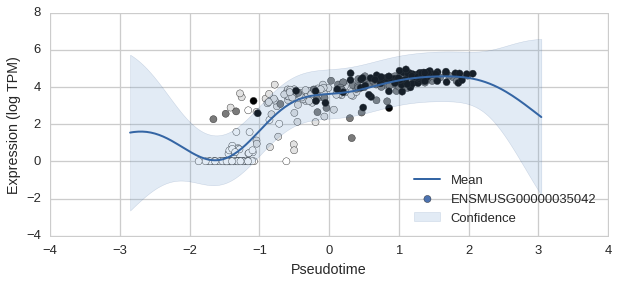

In [212]:
plot_a_gene('ENSMUSG00000035042')

### Slow Response Gense

In [196]:
cluster_membership.query('cluster == 3') \
.join(gene_annotation) \
.join(D) \
.sort_values('log_likelihood', ascending=False) \
.head(15)

,cluster,gene_name,transcript_count,chromosome,gene_start,gene_type,log_likelihood
ENSMUSG00000034459,3,Ifit1,1.0,19,34640871.0,protein_coding,494.510863
ENSMUSG00000045932,3,Ifit2,2.0,19,34550694.0,protein_coding,477.385072
ENSMUSG00000017652,3,Cd40,7.0,2,165055627.0,protein_coding,459.463836
ENSMUSG00000020641,3,Rsad2,3.0,12,26442753.0,protein_coding,443.762335
ENSMUSG00000029561,3,Oasl2,7.0,5,114896936.0,protein_coding,430.119021
ENSMUSG00000026536,3,Mnda,1.0,1,173896345.0,protein_coding,406.094258
ENSMUSG00000078921,3,Tgtp2,2.0,11,49057194.0,protein_coding,397.892862
ENSMUSG00000020638,3,Cmpk2,1.0,12,26469204.0,protein_coding,397.046113
ENSMUSG00000041827,3,Oasl1,6.0,5,114923240.0,protein_coding,390.912394
ENSMUSG00000034422,3,Parp14,3.0,16,35832874.0,protein_coding,378.942579


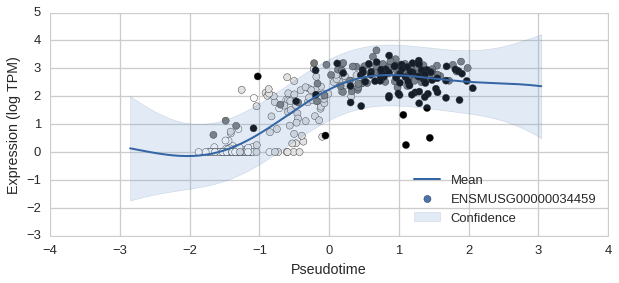

In [217]:
plot_a_gene('ENSMUSG00000034459')

### Bump

In [218]:
cluster_membership.query('cluster == 1') \
.join(gene_annotation) \
.join(D) \
.sort_values('log_likelihood', ascending=False) \
.head(15)

,cluster,gene_name,transcript_count,chromosome,gene_start,gene_type,log_likelihood
ENSMUSG00000045817,1,Zfp36l2,1.0,17,84183931.0,protein_coding,215.978299
ENSMUSG00000053560,1,Ier2,1.0,8,84661331.0,protein_coding,209.596943
ENSMUSG00000015766,1,Eps8,13.0,6,137477245.0,protein_coding,178.218822
ENSMUSG00000038418,1,Egr1,2.0,18,34859823.0,protein_coding,171.840249
ENSMUSG00000032501,1,Trib1,2.0,15,59648350.0,protein_coding,169.158192
ENSMUSG00000037868,1,Egr2,7.0,10,67535475.0,protein_coding,155.795506
ENSMUSG00000098178,1,Yam1,1.0,17,39846958.0,lincRNA,152.081303
ENSMUSG00000051495,1,Irf2bp2,1.0,8,126588296.0,protein_coding,147.505338
ENSMUSG00000036390,1,Gadd45a,5.0,6,67035096.0,protein_coding,136.024180
ENSMUSG00000024663,1,Rab3il1,8.0,19,10001669.0,protein_coding,134.316845


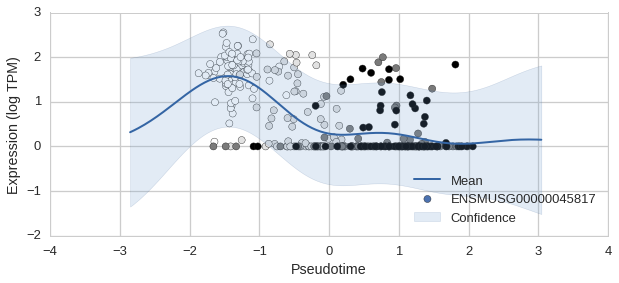

In [223]:
plot_a_gene('ENSMUSG00000045817')